In [2]:
# Paquetes y comandos de interés a importar:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from scipy.optimize import curve_fit
plt.rcParams['figure.dpi']= 90
from PIL import Image
from scipy.fft import fft
import scipy.signal as signal

Comenzamos analizando la imagen de un borde de Mo. La lámina ha sido colocada a 6 cm del sensor, y el sensor está a su vez colocado a 15 cm de la fuente de rayos-X láser. El tiempo de adquisición de la imagen fue de 10 segundos. Para analizar el tamaño de foco en la dirección vertical, tomamos una ROI de la imagen del borde de 300x300 píxeles, con el borde colocado evidentemente en vertical respecto a las filas de píxeles del sensor. Cada elemento del array de 300x300 representa el valor de intensidad (nivel de gris) en ese pixel. 

In [3]:
# Abrimos la ROI del borde seleccionado

I=Image.open("6cm_run4_cropV.tif")
print(I.format, I.size, I.mode)
#I.show()

I_arr=np.asarray(I) # conversión de imagen .tif a array de 300 filas por 300 columnas.

print('valor mínimo:',np.min(I_arr)); print('valor máximo:',np.max(I_arr)) 

TIFF (300, 300) L
valor mínimo: 0
valor máximo: 187


Los valores de intensidad de esta imagen en concreto van de 0 a 187. Como el sensor adquiere imágenes en blanco y negro de 8 bits, vamos a normalizar estos valores, reescalándolos linealmente entre 0 y 255 niveles de gris.

In [4]:
# Normalizamos los valores del array I en un intervalo de niveles de gris [0,GL_max]

def norm(image,GL_max):
    GL=np.zeros((len(image),len(image)))
    GL = GL_max*((image-np.min(image))/(np.max(image)-np.min(image)))
    return GL.astype(int)

I_norm=norm(I_arr,255) #normalizamos a 255 niveles de gris

print('valor mínimo:',np.min(I_norm)); print('valor máximo:',np.max(I_norm))

I_norm_im=Image.fromarray(np.uint8(I_norm)) #lo convierto a imagen

I_norm_im.show()

# Continuaremos trabajando con I_norm, que es, como explicamos antes, la matriz de niveles de gris.

valor mínimo: 0
valor máximo: 255


Construimos ahora la ESF, que no es más que la intensidad de cada punto de la imagen representada versus su posición. Es decir, nos da información de cómo cambia el nivel de gris desde el blanco de la imagen (donde no hay borde) hasta el negro (donde está el borde). Finalmente, como se recomienda en la bibliografía, ajustaremos esta ESF a una función tipo Fermi. El ajuste a Fermi nos permitirá sacar la posición del borde en cada fila con precisión subpixel. 

--- POSICION DEL BORDE EN LA FILA 150 (mm) ----
Mínimo 6.159167429848092
Máximo 6.646208590367749


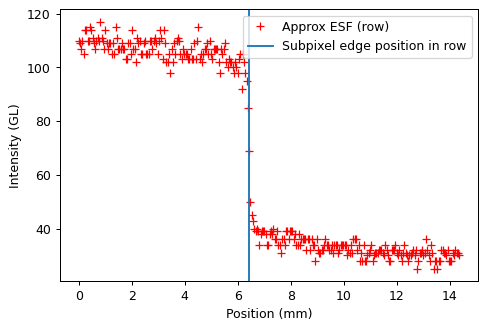

In [5]:
# Vamos a aplicar fermi por filas. El parámetro e es la posición en mm del borde (transición de blanco a negro) 
# en cada fila

def fermi(x,d,b,s,e):
    f = d + (b-d)/(1+np.exp(-s*(x-e))) 
    return f

# Para representar la ESF en función de la posición y no del pixel, necesitamos el tamaño de pixel (48 micras):

pixel_size=0.048 # en mm
image_len=np.sqrt(np.size(I_norm))

# Array que representa el ancho físico de cada fila:

width=np.arange(0,image_len*pixel_size,pixel_size) #de 0 hasta 14.4 en pasos de 0.048

edge_position=[] #aquí me voy a guardar todos los coeficientes e de cada fila

for i in range(len(I_norm)): #recorro el array y me saco las posiciones
    p_f,cov_f=curve_fit(fermi,width,I_norm[i])
    edge_position.append(p_f[3]) 
    
    
# vamos a probar a ver si funciona, sobre una fila aleatoria de la imagen, la i=150:

index=150

plt.plot(width,I_norm[index],'r+',label='Approx ESF (row)')
plt.axvline(x=edge_position[index],label='Subpixel edge position in row')
#plt.xlim([5.5,7])
plt.xlabel('Position (mm)')
plt.ylabel('Intensity (GL)')
plt.legend()

print('--- POSICION DEL BORDE EN LA FILA 150 (mm) ----')
print('Mínimo', np.min(edge_position))
print('Máximo', np.max(edge_position))



Ahora necesitamos saber exactamente cual es el ángulo de inclinación del borde respecto a las columnas del sensor. Para eso, nos cogemos los parámetros e (guardados en el array edge_position) y ajustamos a una recta. Después, construimos un nuevo vector de posiciones ($z$), que representa la posición del borde corregida con este ángulo. De esta manera, "proyectamos" las posiciones del borde en cada fila  sobre los nuevos ejes para alinearlo y tener una ESF centrada. 

$$ z_i = (x_i - e_i)\cdot cos\theta$$

Donde $z_i$ es la nueva posición de la imagen, $x_i$ es la posición sin rotar en I_norm, $e_i$ es la posición del borde en la y $\theta$ el ángulo de tilt respecto a la vertical, sacado de la pendiente del ajuste que mostramos a continuación. El subíndice i indica la fila i de la imagen.

Parámetros del ajuste: pendiente y ordenada en el origen: [  32.49522878 -201.4436546 ]
Angulo con y 1.7626496293454472


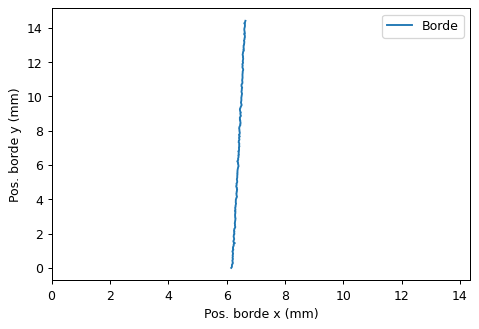

In [6]:
def f(x,a,b): # recta
    y=a*x+b
    return y

width_inverse=np.linspace(image_len*pixel_size,0,300)

plin,covlin=curve_fit(f,edge_position,width_inverse,p0=[1,10]) #ajuste

print('Parámetros del ajuste: pendiente y ordenada en el origen:',plin)
#print(np.sqrt(np.diag(covlin)))

#len(width)


plt.plot(edge_position,width_inverse,'-',label='Borde')

angle=(pi/2-np.arctan(plin[0]))*180/pi # ángulo en grados a partir del parámetro a (plin[0])

print('Angulo con y',angle)

plt.xlim([0,np.max(width)])
plt.xlabel('Pos. borde x (mm)')
plt.ylabel('Pos. borde y (mm)')
plt.legend()

# nos construimos el vector z

z=np.zeros((len(width),len(width)))
theta=(pi/2)-np.arctan(plin[0]) # es angle en radianes

for i in range(len(edge_position)):
    z[i]=(width-edge_position[i])*np.cos(theta)

Text(0.5, 1.0, 'Oversampled ESF')

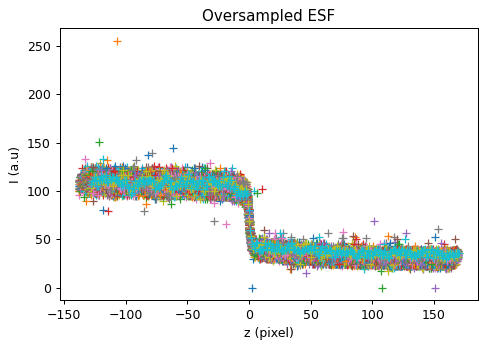

In [7]:
# La representación de I_norm versus z, recorriendo todas las filas de la imagen, es en sí la ESF.

for i in range(len(z)):
    plt.plot(z[i,:]/pixel_size,I_norm[i,:],'+')
    
    
plt.xlabel('z (pixel)')
plt.ylabel('I (a.u)')

#OVERSAMPLED ESF

plt.title('Oversampled ESF')

#plt.xlim([-20,20])



Text(0.5, 1.0, 'Oversampled ESF')

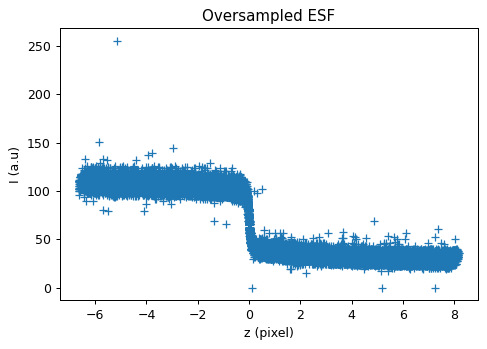

In [8]:
# Nos lo llevamos todo a dos arrays:

z_stack=np.hstack(z) # todas las posiciones de todas las filas
I_stack=np.hstack(I_norm) # todas las intensidades de todas las filas


plt.plot(z_stack,I_stack,'+') # Es lo mismo que la figura anterior.

plt.xlabel('z (pixel)')
plt.ylabel('I (a.u)')

#OVERSAMPLED ESF

plt.title('Oversampled ESF')


Al hacer sobre-muestreo se acentúa lo ruidosa que es la imagen. Aquí empiezan mis problemas. Ajustamos esta ESF de nuevo a fermi, tanto para poder derivarla posteriormente como para re-muestrearla. Necesitamos que los puntos estén equiespaciados para poder realizar posteriormente una derivada sencilla (para calcular la LSF).

(0.0, 150.0)

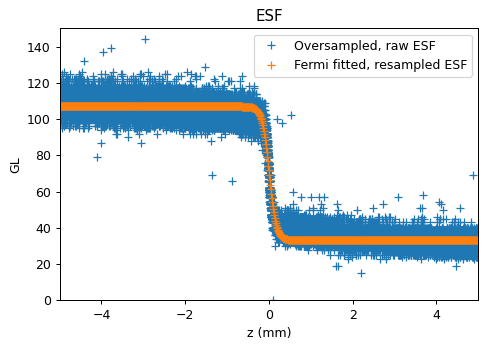

In [9]:
plt.plot(z_stack,I_stack,'+', label='Oversampled, raw ESF')

pe,cove=curve_fit(fermi,z_stack,I_stack)

#print(pe)
#print(np.sqrt(np.diag(cove)))

sample=pixel_size/4 # escogemos una distancia de muestreo de 1/4 del tamaño de pixel.

z_resample=np.arange(np.min(z_stack),np.max(z_stack),sample) 
I_resample=fermi(z_resample,*pe)

plt.plot(z_resample,I_resample,'+',label='Fermi fitted, resampled ESF')
plt.xlim([-5,5])

plt.title('ESF')

plt.xlabel('z (mm)')
plt.ylabel('GL')

plt.legend()

plt.ylim([0,150])



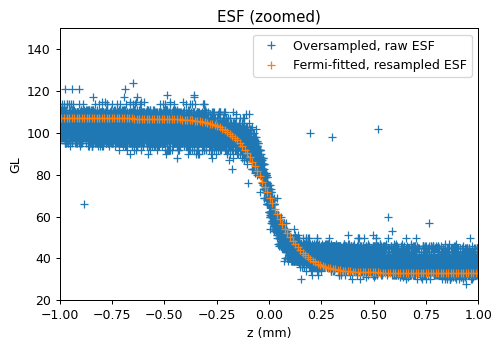

In [10]:
# Vamos a hacer zoom en el borde
plt.plot(z_stack,I_stack,'+', label='Oversampled, raw ESF')
plt.plot(z_resample,I_resample,'+', label='Fermi-fitted, resampled ESF')
plt.xlim([-1,1])
plt.ylim([20,150])
plt.title('ESF (zoomed)')
plt.xlabel('z (mm)')
plt.ylabel('GL')
plt.legend()

Como vemos en la figura anterior, al ajuste a Fermi no reconstruye bien la transición del borde. Cuanto más se aleje la ESF de una función escalón perfecta, mayor será el ancho de nuestra gaussiana (ergo mayor será el tamaño de foco que nos reporte). La ESF reconstruida (en naranja) parece a simple vista que está más lejos de la función escalón que la ESF original (la azul). Entiendo que la cantidad de ruido que hay en la imagen es lo que está dificultando un ajuste a Fermi que reproduzca correctamente la calidad de la imagen, por lo que esta necesita un filtrado. De momento continuamos el análisis con la ESF sin filtrar.

Text(0.5, 0, 'z (mm)')

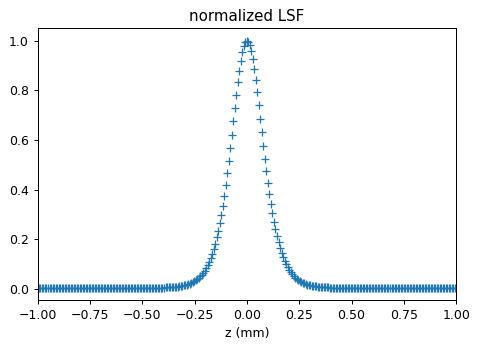

In [11]:
# Construimos la LSF como la derivada simple de la ESF.

LSF=1-np.diff(I_resample)/np.diff(z_resample) # Hago 1-derivada para que sea una función positiva.
LSF_norm=LSF/np.max(LSF) # normalizamos

# construimos un nuevo z que represente el centro de cada pixel, teniendo en cuenta la magnificación: 
z_diff=np.zeros(len(z_resample)-1) 

m=15/9 # magnificación m=(9+6)/9, donde distancia fuente-borde = 9 cm y distancia borde-sensor = 6 cm.

for i in range(len(z_resample)-1):
    z_diff[i] = ((z_resample[i+1]+z_resample[i])/2)/m 

plt.plot(z_diff,LSF_norm,'+')
plt.xlim([-1,1])

plt.title('normalized LSF')

plt.xlabel('z (mm)')


Sigma (mm) 0.07667643264291797
FWHM (mm)  0.18057299887407183
------Tamaño de foco en la dirección vertical-----------
180.57299887407183 micras


(-1.0, 1.0)

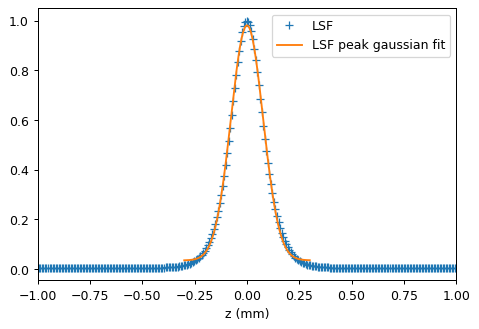

In [12]:
# Esto que viene a continuación es un ajuste gaussiano al pico de la LSF.

def gauss(x,a,b,c,d,f):
    gauss=a*np.exp((-(x-b)**2)/(2*c**2))+d*x+f
    return gauss

## Para aislar el pico, necesitamos estas dos funciones:

# Definimos selector de canales de posición:

def can(canal,counts,inf,sup):
    canal_lst=[] #definimos una lista vacía
    for i in range(len(canal)): #recorremos el array de canales
        if canal[i]>=inf and canal[i]<=sup: #[inf,sup] es el intervalo de canales a seleccionar
            canal_lst.append(canal[i]) 
    canal_arr=np.array(canal_lst) #convertimos la lista a array
    return canal_arr

# Definimos selector de amplitudes (intensidades):

def amp(canal,counts,inf,sup): #lo mismo que can() pero para obtener el array de amplitudes parejo al de canales
    ampl_lst=[]
    for i in range(len(canal)):
        if canal[i]>=inf and canal[i]<=sup:
            ampl_lst.append(counts[i])
    ampl_arr=np.array(ampl_lst)
    return ampl_arr


z_p=can(z_diff,LSF_norm,-0.3,0.3) # selección del pico en términos de posición
LSF_p=amp(z_diff,LSF_norm,-0.3,0.3) # selección del pico en términos de amplitud

p_g,cov_g=curve_fit(gauss,z_p,LSF_p) # Ajustamos a gauss

#print(p_g)
#print(np.sqrt(np.diag(cov_g)))


z_lin=np.linspace(-0.3,0.3,1000)
LSF_lin=gauss(z_lin,*p_g)

plt.plot(z_diff,LSF_norm,'+', label='LSF')
plt.plot(z_lin,LSF_lin, label='LSF peak gaussian fit')
plt.xlabel('z (mm)')
plt.legend()

print('Sigma (mm)', p_g[2])
print('FWHM (mm) ', 2.355*p_g[2]) 

print('------Tamaño de foco en la dirección vertical-----------')
print(2.355*p_g[2]*1000,'micras')

plt.xlim([-1,1])



$\Large{\text{FILTRADO PASA-BAJA}}$

El tamaño del foco que reporta el análisis de la ESF sin filtrar es demasiado grande. Voy a intentar filtrar el ruido con un filtro Butterworth tipo pasa-baja. Hago primero Fast Fourier Transform para ver el comportamiento de la función en frecuencias, y así poder estimar la frecuencia de corte para el filtro.

Recordamos que la ESF original es I_stack versus z_stack.

Text(0, 0.5, 'FFT(ESF)')

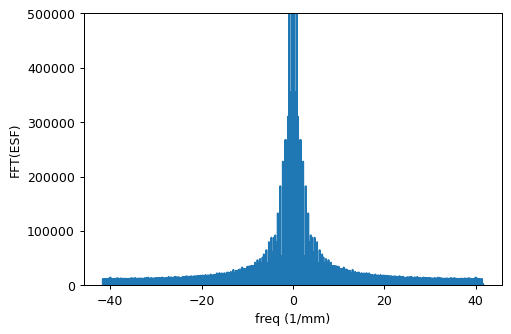

In [13]:
fft_I=np.fft.fft(I_stack)
n=len(I_stack)
freq=np.fft.fftfreq(n=n,d=sample) #array de frecuencias en funcion de la distancia de muestreo (sample=pixel_size/4)

plt.plot(freq,np.abs(fft_I))

#Hacemos zoom porque sino no se ve nada

plt.ylim([0,0.5E6])

plt.xlabel('freq (1/mm)')
plt.ylabel('FFT(ESF)')

(20.0, 150.0)

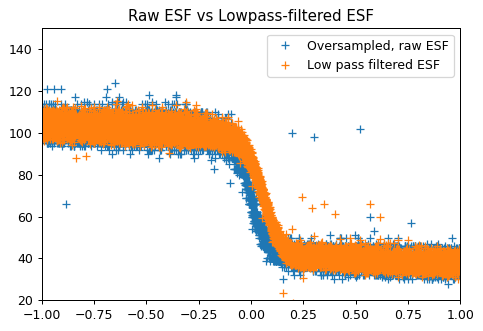

In [14]:
# Filtrado de la ESF

# signal.butter(orden filtro, frecuencia corte, tipo filtro, frecuencia de muestreo, output)

sos_ESF = signal.butter(2, 15 ,'low', fs=4/pixel_size, output='sos')

# He jugado con varios pares de orden de filtro y frecuencia de corte y este parece el menos malo

I_filt = signal.sosfilt(sos_ESF, I_stack) # lo aplico a la ESF

plt.plot(z_stack,I_stack,'+', label='Oversampled, raw ESF')
plt.plot(z_stack,I_filt,'+', label='Low pass filtered ESF')

plt.title('Raw ESF vs Lowpass-filtered ESF')

plt.legend()

plt.xlim([-1,1])
plt.ylim([20,150])


Text(0.5, 1.0, 'Filtered ESF and its Fermi fit')

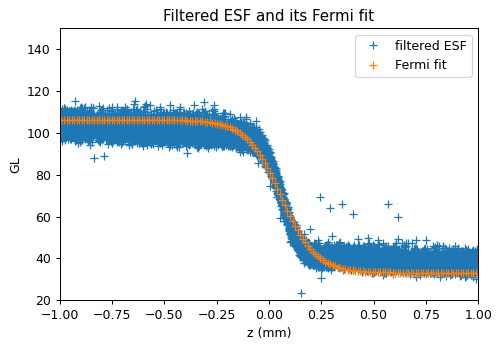

In [18]:
# Ajustamos la filtrada a Fermi

p_f,cov_f=curve_fit(fermi,z_stack,I_filt)

I_filt_resample=fermi(z_resample,*p_f)

#plt.plot(z_stack,I_stack,'+',label='raw ESF')
plt.plot(z_stack,I_filt,'+',label='filtered ESF')

#plt.plot(z_resample,I_resample,'+',label='Fermi fitted, no filter ESF')
plt.plot(z_resample,I_filt_resample,'+',label='Fermi fit')
plt.xlim([-1,1])
plt.ylim([20,150])
plt.xlabel('z (mm)')
plt.ylabel('GL')
plt.legend()

plt.title('Filtered ESF and its Fermi fit')

Text(0.5, 0, 'z (mm)')

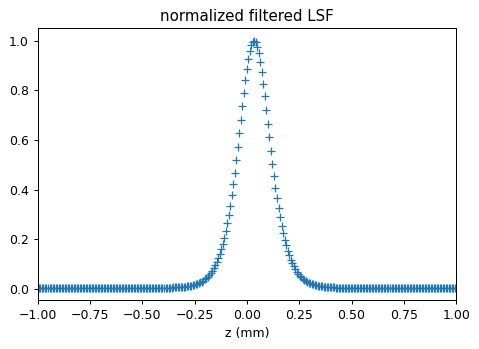

In [19]:
# Construimos la LSF como la derivada simple de la ESF.

LSF_filt=1-np.diff(I_filt_resample)/np.diff(z_resample) # Hago 1-derivada para que sea una función positiva.
LSF_filt_norm=LSF_filt/np.max(LSF_filt) # normalizamos

# construimos un nuevo z que represente el centro de cada pixel, teniendo en cuenta la magnificación: 
z_diff=np.zeros(len(z_resample)-1) 

m=15/9 # magnificación m=(9+6)/9, donde distancia fuente-borde = 9 cm y distancia borde-sensor = 6 cm.

for i in range(len(z_resample)-1):
    z_diff[i] = ((z_resample[i+1]+z_resample[i])/2)/m 

plt.plot(z_diff,LSF_filt_norm,'+')
plt.xlim([-1,1])

plt.title('normalized filtered LSF')

plt.xlabel('z (mm)')


Sigma (mm) 0.07498196591326403
FWHM (mm)  0.1765825297257368
------Tamaño de foco en la dirección vertical, filtro BW-----------
176.5825297257368 micras


Text(0.5, 1.0, 'Normalized filtered LSF and Gaussian fit to peak')

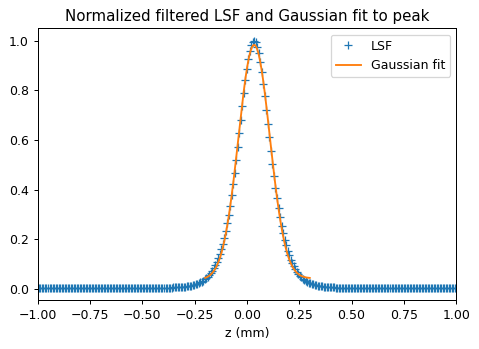

In [21]:
# Fit gaussiano a la LSF filtrada

z_filt_p=can(z_diff,LSF_filt_norm,-0.25,0.3) # selección del pico en términos de posición
LSF_filt_p=amp(z_diff,LSF_filt_norm,-0.25,0.3) # selección del pico en términos de amplitud

p_filt_g,cov_filt_g=curve_fit(gauss,z_filt_p,LSF_filt_p) # Ajustamos a gauss


z_lin=np.linspace(-0.2,0.3,1000)
LSF_filt_lin=gauss(z_lin,*p_filt_g)

plt.plot(z_diff,LSF_filt_norm,'+', label='LSF')
plt.plot(z_lin,LSF_filt_lin, label='Gaussian fit')
plt.xlabel('z (mm)')
plt.legend()

print('Sigma (mm)', p_filt_g[2])
print('FWHM (mm) ', 2.355*p_filt_g[2]) 

print('------Tamaño de foco en la dirección vertical, filtro BW-----------')
print(2.355*p_filt_g[2]*1000,'micras')

plt.xlim([-1,1])
plt.title('Normalized filtered LSF and Gaussian fit to peak')



Con el filtro el tamaño de foco es un poco más pequeño (180 micras vs 176 micras) pero sigue estando muy lejos de lo esperado.